In [1]:
import pandas as pd

from preprocessing import remove_floating_points_in_postcodes, check_postcodes, convert_order_date_to_datetime

## Data loading and checking

In [2]:
df = pd.read_csv("../data/interview_signup.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318345 entries, 0 to 318344
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   original_product_name  318345 non-null  object 
 1   postcode               318345 non-null  object 
 2   bundesland             288813 non-null  object 
 3   total_bonus            318345 non-null  float64
 4   order_date             318345 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.1+ MB


/tmp/ipykernel_75212/4243634050.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/interview_signup.csv")


In [3]:
df.head()

,original_product_name,postcode,bundesland,total_bonus,order_date
0,E.ON STROM,53229.0,Nordrhein-Westfalen,146.0,2018-01-01
1,E.ON STROM ÖKO,74235.0,Baden-Württemberg,67.0,2018-01-01
2,E.ON STROM ÖKO 24,45257.0,Nordrhein-Westfalen,123.0,2018-01-01
3,E.ON STROM,64395.0,Hessen,159.0,2018-01-01
4,E.ON STROM 24,36039.0,Hessen,116.0,2018-01-01


In [4]:
df.describe(include='all')

,original_product_name,postcode,bundesland,total_bonus,order_date
count,318345,318345.0,288813,318345.000000,318345
unique,10,20525.0,16,NaN,365
top,E.ON STROM,31515.0,Nordrhein-Westfalen,NaN,2018-09-05
freq,164473,332.0,68541,NaN,960
mean,NaN,NaN,NaN,150.590275,NaN
std,NaN,NaN,NaN,53.692176,NaN
min,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,112.000000,NaN
50%,NaN,NaN,NaN,149.000000,NaN
75%,NaN,NaN,NaN,182.000000,NaN


We can already see the first two issues:
* The 'postcode' column is stored as an object data type, but it should be an integer since it is a 5-digit number. The warning "DtypeWarning" raised during the data loading also indicates that the column contains mixed types. First values end with '.0', indicating that some values are wrongly formatted as floating point numbers. There are approximately 8,699 different postcodes in Germany, but we have 20,525 different values.
* The 'order_date' column is an object data type, it should be converted to a datetime data type in order to enable using time-based operations, such as resampling and date filtering, and to insure a more efficient storage.

In [5]:
df['original_product_name'].unique()

array(['E.ON STROM', 'E.ON STROM ÖKO', 'E.ON STROM ÖKO 24',
       'E.ON STROM 24', 'E.ON STROM PUR', 'E.ON STROM Ã–KO',
       'E.ON STROM 24 24 24', 'E.ON STROM 24 24', 'E.ON STROM ÖO',
       'E.ON STROM 24 24 24 24 24 24 24'], dtype=object)

* There seem to be misspellings withing the 'original_product_name' categories, e.g. 'E.ON STROM' and 'E.ON STROM 24 [...] 24', 'E.ON STROM ÖKO' and 'E.ON STROM ÖO'.

In [6]:
df['bundesland'].unique()

array(['Nordrhein-Westfalen', 'Baden-Württemberg', 'Hessen', 'Berlin',
       'Schleswig-Holstein', 'Niedersachsen', nan, 'Bayern',
       'Rheinland-Pfalz', 'Sachsen', 'Bremen', 'Brandenburg', 'Thüringen',
       'Saarland', 'Mecklenburg-Vorpommern', 'Hamburg', 'Sachsen-Anhalt'],
      dtype=object)

In [7]:
df.isna().sum()

original_product_name        0
postcode                     0
bundesland               29532
total_bonus                  0
order_date                   0
dtype: int64

* There are 29532 rows with missing 'bundesland' values. It should be possible to impute the correct states from postcodes (after cleaning that column), but will require mapping data.

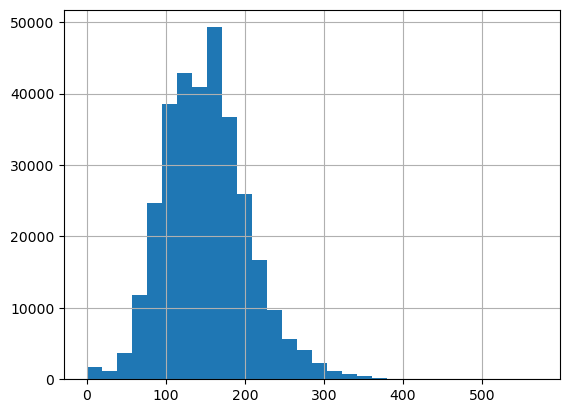

In [8]:
df.total_bonus.hist(bins=30);

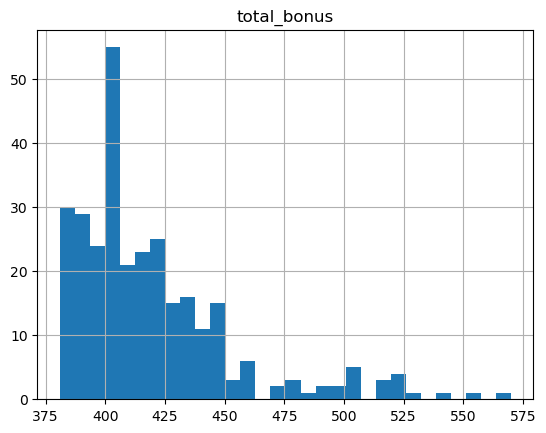

In [9]:
high_bonus = df[df['total_bonus'] > 380]
high_bonus.hist(bins=30);

In [10]:
print(f"{round(len(high_bonus) / len(df) * 100, 2)}% of customer signups received total bonus above 380€.")

0.09% of customer signups received total bonus above 380€.


Looking at the histograms above, we can see another minor issue:
* There are 0.09% extraordinaty high 'total_bonus' values above 380(€?), with a peak around 400.
The minimal value is 0, mean value is 149 and maximal value of 570.
Domain knowledge is required in order to decide if they are outliers that should be removed for modeling.

## Resolving selected issues

### Cleaning 'postcodes' column by removing floating point numbers

In [11]:
df = pd.read_csv("../data/interview_signup.csv", dtype={'postcode': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318345 entries, 0 to 318344
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   original_product_name  318345 non-null  object 
 1   postcode               318345 non-null  object 
 2   bundesland             288813 non-null  object 
 3   total_bonus            318345 non-null  float64
 4   order_date             318345 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.1+ MB


In [12]:
df['postcode'].unique()

array(['53229', '74235.0', '45257', ..., '79424.0', '27246.0', '67473.0'],
      dtype=object)

In [13]:
df['postcode'].nunique()

15814

In [14]:
df.head()

,original_product_name,postcode,bundesland,total_bonus,order_date
0,E.ON STROM,53229,Nordrhein-Westfalen,146.0,2018-01-01
1,E.ON STROM ÖKO,74235.0,Baden-Württemberg,67.0,2018-01-01
2,E.ON STROM ÖKO 24,45257,Nordrhein-Westfalen,123.0,2018-01-01
3,E.ON STROM,64395,Hessen,159.0,2018-01-01
4,E.ON STROM 24,36039,Hessen,116.0,2018-01-01


In [15]:
df = remove_floating_points_in_postcodes(df)
df.head()

,original_product_name,postcode,bundesland,total_bonus,order_date
0,E.ON STROM,53229,Nordrhein-Westfalen,146.0,2018-01-01
1,E.ON STROM ÖKO,74235,Baden-Württemberg,67.0,2018-01-01
2,E.ON STROM ÖKO 24,45257,Nordrhein-Westfalen,123.0,2018-01-01
3,E.ON STROM,64395,Hessen,159.0,2018-01-01
4,E.ON STROM 24,36039,Hessen,116.0,2018-01-01


In [16]:
df['postcode'].nunique()

8084

Removing floating point numbers led to reduction of unique values from 20,525 to 8,084 that is close to the number of postcodes in Germany.

In [17]:
check_postcodes(df)

Found 1 postcodes with non-numeric values in column 'postcode'.
266922    92696JAVAS
Name: postcode, dtype: object
Found 39095 postcodes with invalid length (not 5 digits) in column 'postcode'.


While working of the first issue, I found two more issues:
* The 'postcode' column contains 1 postcode with non-numeric value: '92696JAVAS'.
* The 'postcode' column contains 39095 postcodes with invalid length (not 5 digits).

### Converting 'order_date' column to a datetime data type

In [18]:
df = convert_order_date_to_datetime(df)
df['order_date'].dtype # dtype('<M8[ns]'): a datetime data type with nanosecond (ns) precision

dtype('<M8[ns]')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318345 entries, 0 to 318344
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   original_product_name  318345 non-null  object        
 1   postcode               318345 non-null  object        
 2   bundesland             288813 non-null  object        
 3   total_bonus            318345 non-null  float64       
 4   order_date             318345 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 12.1+ MB
